# 06. Transfer learning with PyTorch

What is transfer learning?

Transfer learning involves learning the paremters of what one model has learned on another dataset and applying them to our own problem.

* Pretrained model = foundation models: https://pytorch.org/vision/stable/index.html (torchvision)

**Resources:**

Resource notebook: https://www.learnpytorch.io/06_pytorch_transfer_learning/

Ask questions: https://github.com/mrdbourke/pytorch-...

Access code: https://github.com/mrdbourke/pytorch-deep-learning

Ground truth notebook: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/06_pytorch_transfer_learning.ipynb

PyTorch cheat sheet: https://pytorch.org/tutorials/beginner/ptcheat.html

## 0. Getting setup

torchvision: https://pytorch.org/vision/stable/index.html

In [1]:
import torch
import torchvision

print(torch.__version__) # want 1.12+
print(torchvision.__version__) # want 0.13+

2.3.1+cu121
0.18.1+cu121


In [2]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+ (if you don't have updated API's run this)
# try:
#     import torch
#     import torchvision
#     assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
#     assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
#     print(f"torch version: {torch.__version__}")
#     print(f"torchvision version: {torchvision.__version__}")
# except:
#     print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
#     !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
#     import torch
#     import torchvision
#     print(f"torch version: {torch.__version__}")
#     print(f"torchvision version: {torchvision.__version__}")

Let's import the code we've written in the previous sections so that we don't have to write it again (mainly from notebook 05: Going Modular)

In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 16.68 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [4]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

We need our pizza, steak, sushi data to build a transfer learning model on.

In [5]:
import os
import zipfile

from pathlib import Path

import requests

# Setup data path
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi" # images from a subset of classes from the Food101 dats

# If the image folder doesn't exist, download it from github and prepare it
if image_path.is_dir():
  print(f"{image_path} already exists, skipping re-download...")
else:
  print(f"Did not find {image_path}, downloading it...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download steak, sushi, pizza data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data..")
  zip_ref.extractall(image_path)

# Remove zip file
os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi, downloading it...
Unzipping pizza, steak, sushi data..


In [6]:
# Setup directory path
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Datasets and DataLoaders

Now we've got some data, want to turn it into PyTorch DataLoaders.

To do so, we can use `data_setup.py` and the `create_dataloaders()` function we made in 05. PyTorch Going Modular notebook.

There's one thing we have to think about when loading: how to **transform** it?

And with `torchvision` 0.13+ there's two ways to do this:

1. Manually created transforms - you define what transforms you want your data to go through
2. Automatically created transforms - the transforms for your data are defined by the model you'd like to use.

Important point: when using a pretrained model, it's important that the data (including your custom data) that you pass through it is **transformed** in the same way that way that the data the model was trained on.


In [8]:
# from going_modular.going_modular import data_setup

# train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders()


### 2.1 Creating a transform for `torchvision..models` (manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right within `torchvision`

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize.
>
>
* Pro: infintely customizable
* Con: if the wrong transform is used, model's performance will degrade

In [9]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize((224,224)), # resize image to 224, 224 (height x width)
    transforms.ToTensor(), # get images jnto range [0, 1]
    normalize ]) # make sure images have the same distribution as ImageNet (where our pretrained models have been trained)

In [10]:
from going_modular.going_modular import data_setup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = manual_transforms,
                                                                               batch_size = 32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x782671edf7f0>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As of `torchvision` v0.13+, there is now support for automatic data transform creation based on the pretrained model weights you're using.

Efficientnet: https://pytorch.org/vision/main/models/efficientnet.html
* using efficientnetb0 for our first model

In [11]:
# Get a set of pretrained weights (patterns model has learned on ImageNet, and we want to leverage those patterns for our own data)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # DEFAULT = best available/performing weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [12]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [13]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = auto_transforms,
                                                                               batch_size=32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78266a8956f0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

There are various places to get a pretrained model, such as:
1. PyTorch domain libraries
2. Libraries like `timm` (torch image models)
3. Hugging Face Hub (for plenty of different models)
4. Paperswithcode (for models across different problem spaces/domains)

### 3.1 Which pretrained model should you use?

*Experiment, experiment, experiment!*

The whole idea of transfer learning: take an already well-performing model from a problem sapce similar to your own and then customize to your own problem.

Three things to consider:
1. Speed - how fast does it run?
2. Size - how big is the model?
3. Performance - how well does it go on your chosen problem (our model: how well does it classify food images?)

Where does the model live?

Is it on device? (like on a self-driving car)

Or does it live on a server?

Looking at https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights

Which model should we chose?

For our case (deploying FoodVision Mini on a mobile device, we want a model with best performance and lowest amount of Params (size) so EffNetB0 for our case)

However, in light of The Bitter Lesson (http://www.incompleteideas.net/IncIdeas/BitterLesson.html?ref=blog.heim.xyz), if we had infinite compute, we'd likely pick the biggest model + most parameters + most general model.

### 3.2 Setting up a pretrained model

Want to create an instance of pretrained EffNetB0 - https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.EfficientNet_B0_Weights

In [14]:
# OLD method of creating a pretrained model (prior to torchvision v0.13)
# model = torchvision.models.efficientnet_b0(pretrained=True)

# New method of creating a pretrained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # ".DEFAULT" = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 176MB/s]


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [15]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of our model with `torchinfo.summary()`

In [16]:
# Print with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1,3,224,224), # example of [batch_size, color_channels, height, width]
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the output layer to suit our needs

* With a feature extractor model, typically you will "freeze" the base layers of a pre-trained/foundation model and update the output layers to suit your own problem.

* We want to freeze them as we don't want them to be updated when we are traing them with our own data because we are using the weights these layers have already learned from ImageNet. We freeze all the layers except the output layers.

* Dropout: https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

In [17]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [18]:
# Freeze all the base layers in EffectB0
for param in model.features.parameters():
  # print(param)
  param.requires_grad = False # freezes all the parameters except the output layer

In [19]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, # features vector coming in
              out_features=len(class_names))).to(device) # how many classes do we have?

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [20]:
summary(model=model,
        input_size=(1,3,224,224), # example of [batch_size, color_channels, height, width]
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Train model

In [26]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
# Import train function
from going_modular.going_modular import engine

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.1845 | train_acc: 0.9844 | test_loss: 0.3707 | test_acc: 0.8352
Epoch: 2 | train_loss: 0.1818 | train_acc: 0.9883 | test_loss: 0.3448 | test_acc: 0.8456
Epoch: 3 | train_loss: 0.1789 | train_acc: 0.9805 | test_loss: 0.3571 | test_acc: 0.8248
Epoch: 4 | train_loss: 0.2043 | train_acc: 0.9961 | test_loss: 0.3464 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.1665 | train_acc: 0.9922 | test_loss: 0.3657 | test_acc: 0.8561
[INFO] Total training time: 12.955 seconds


## 5. Evaluate model by plotting loss curves

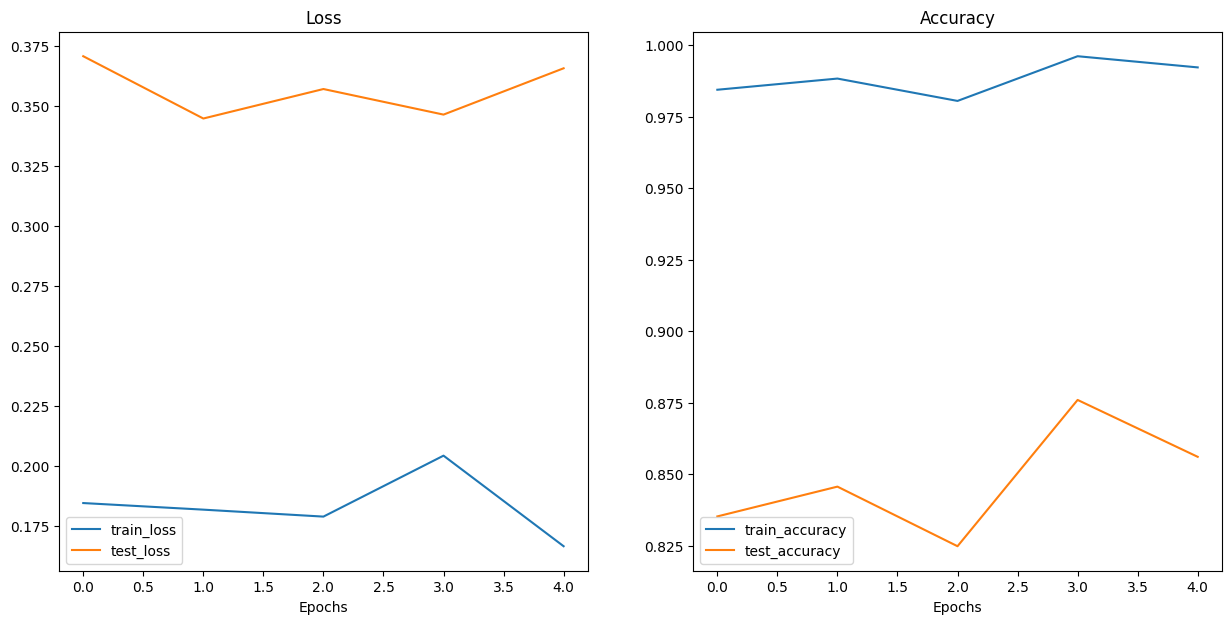

In [32]:
try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] couldn't find helper_functions.py, downloading..")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

## 6. Make predictions on images from the test set

Let's adhere to the data explorer's motto of *visualize, visualize, visualize*

Some things to keep in mind when making qualitative predictions/inference on test data/custom data.

We have to make sure that our test/custom data:
* Same shape - images need to be same shape as model was trained on
* Same datatype - custom data should be in the same data type
* Same device - custom data/test data should be on the same device as the model
* Same transform - if you've transformed your custom data, ideally you will transform the test data and custom data the same

To do all of this automatically, let's create a fucntion called `pred_and_plot_image()`

The function will be similar to the one here: The function will be similar to the one here: https://www.learnpytorch.io/04_pytorch_custom_datasets/#13-putting-custom-image-prediction-together-building-a-function

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device
2. Open the image with `PIL.Image.Open()`
3. Create a transform if one doesn't exist
4. Make sure the model and data is on the target device
5. Turn the model to `model.eval()` mode to make sure it's ready for inference (this will turn off things like things like `nn.Dropout()`)
6. Transform the target image and make sure its dimensionality is suited for the model (this mainly relates to batch size)
7. Make a prediction on the iamge by passing to the model.
8. Conver the model's output logits to prediction probabilites using `torch.softmax()`
9. Convert model's prediction probabilites to prediction labels using `torch.argmax()`
10. Plot the iamge with `matplotlib` and set the tile to the prediction label fro. step 9 and prediction probability from step 8.


In [38]:
from typing import List, Tuple

from PIL import Image

from torchvision import transforms

# 1. Take in a trained model...
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms  = None,
                        device: torch.device = device):
  # 2. Open the image with PIL
  img = Image.open(image_path)

  # 3. Create a transform if one doesn't exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],
                             std=[0.229,0.224,0.225])

    ])

  ### Predict on image ###
  # 4. Make sure the model is on target device
  model.to(device)

  # 5. Turn on inference mode and eval mode
  model.eval()
  with torch.inference_mode():
    # 6. Transform the iamge and add an extra batch dimension (dealing with 1 image at a time but model expects a batch dimension)
    transformed_image = image_transform(img).unsqueeze(dim=0) # [batch_size, color_channels, height, width]

    # 7. Make a prediction on the transformed image by passing it to the model (also make sure it's on the target device)
    target_image_pred = model(transformed_image.to(device))

  # 8. Convert logits -> pred probs
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # 9. Convert pred probs -> pred labels
  target_image_pred_labels = torch.argmax(target_image_pred_probs, dim=1)

  # 10. Plot the image with predicited labels and prob
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred: {class_names[target_image_pred_labels]} Prob: {target_image_pred_probs.max():.3f}")
  plt.axis(False);

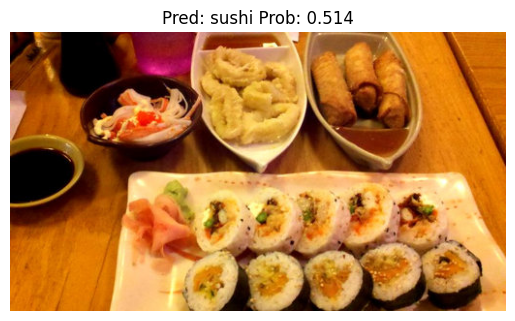

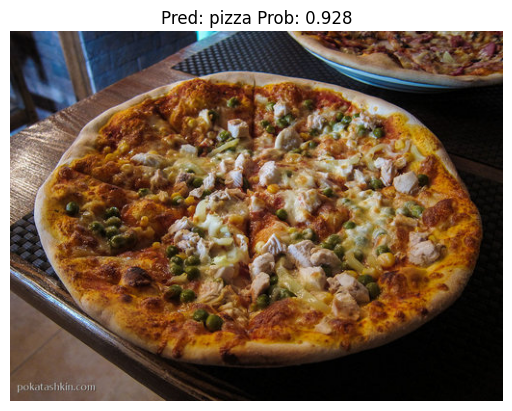

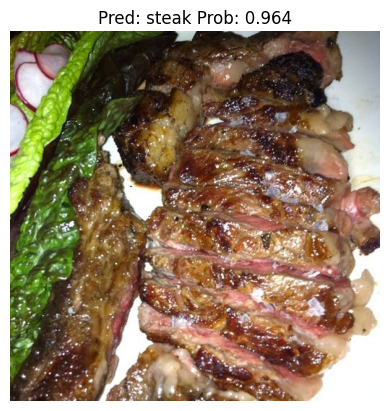

In [40]:
# Get a random list of image paths from the test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)

# Make predicitons on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model,
                      image_path=image_path,
                      class_names=class_names,
                      image_size=(224,224))

### 6.1 Making predictions on a custom image

Let's make a prediction on the pizza dad image - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg

In [41]:
# Download the image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # Download image from github with "raw" link
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/images/04-pizza-dad.jpeg")
    print(f"Downloading {custom_image_path}..")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download...")

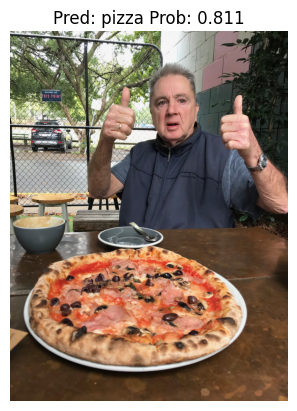

In [42]:
# Predict on custom image
pred_and_plot_image(model=model,
                    image_path = custom_image_path,
                    class_names=class_names)

## Exercises & Extra-curriculum

* **Transfer learning** often allows to you get good results with a relatively small amount of custom data.
* Knowing the power of transfer learning, it's a good idea to ask at the start of every problem, "does an existing well-performing model exist for my problem?"
* When using a pretrained model, it's important that your custom data be formatted/preprocessed in the same way that the original model was trained on, otherwise you may get degraded performance.
* The same goes for predicting on custom data, ensure your custom data is in the same format as the data your model was trained on.
* There are several different places to find pretrained models from the PyTorch domain libraries, HuggingFace Hub and libraries such as timm (PyTorch Image Models): https://www.learnpytorch.io/06_pytorch_transfer_learning/#where-to-find-pretrained-models

**Exercises:**
* Qs: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/06_pytorch_transfer_learning_exercises.ipynb
* Ans: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb
* Vid solutions: https://youtu.be/ueLolShyFqs

**Extra-curriculum:**
* https://www.learnpytorch.io/06_pytorch_transfer_learning/#extra-curriculum